# Install Necessary Packages

In [1]:
# ! pip install ase
# ! pip install git+https://github.com/bigd4/PyNEP.git


# Import Necessary Packages

In [2]:
from ase.io import read,write
from matplotlib.colors import LogNorm
import os
from pylab import *
from pynep.calculate import NEP
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
from pynep.select import FarthestPointSample

# Custom Function Define

In [3]:
# ----------------------------- Set up Figure Styles ------------------------- #
aw = 2
fs = 16
font = {'size': fs}
matplotlib.rc('font', **font)
matplotlib.rc('axes', linewidth=aw)


def set_fig_properties(ax_list,panel_color_str='black',line_width = 2):
    tl = 10
    tw = 2
    tlm = 6

    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in',
                       right=False, top=False)
        ax.spines['bottom'].set_color(panel_color_str)
        ax.spines['top'].set_color(panel_color_str)
        ax.spines['left'].set_color(panel_color_str)
        ax.spines['right'].set_color(panel_color_str)

        ax.spines['bottom'].set_linewidth(line_width)
        ax.spines['top'].set_linewidth(line_width)
        ax.spines['left'].set_linewidth(line_width)
        ax.spines['right'].set_linewidth(line_width)

        for t in ax.xaxis.get_ticklines(): t.set_color(panel_color_str)
        for t in ax.yaxis.get_ticklines(): t.set_color(panel_color_str)
        for t in ax.xaxis.get_ticklines(): t.set_linewidth(line_width)
        for t in ax.yaxis.get_ticklines(): t.set_linewidth(line_width)

# Generate Test Data for Parity Plot Functionality

In [4]:
 # Set up NEP calculator
nep_calculator = NEP('nep5_full.txt')

    # Append ground truth
energy_ground_truth = []
energy_predictions = []
force_ground_truth = []
force_predictions = []

    # Acess iter4 configs
iter4_configs_from_ground_truth = read('test.traj', index=':')
for traj in iter4_configs_from_ground_truth:
    energy_ground_truth.append(traj.get_potential_energy())
    force_ground_truth.append(traj.get_forces().reshape(-1))
    
for traj in iter4_configs_from_ground_truth:
    traj.calc = nep_calculator
    energy_predictions.append(traj.get_potential_energy())
    force_predictions.append(traj.get_forces().reshape(-1))

In [6]:
calc = NEP('nep5_full.txt')
strucs = read('test.traj', index=':')
des = np.array([np.mean(calc.get_property('descriptor', i), axis=0) for i in strucs])
sampler = FarthestPointSample(min_distance=0.05)
selected_i = sampler.select(des, [])
write('selected.traj', [strucs[i] for  i in selected_i])

# Force and Energy Parity Plots

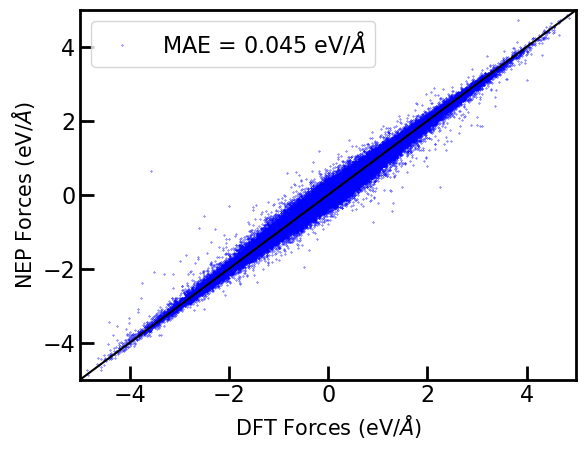

In [7]:
set_fig_properties([gca()])
f1=np.concatenate(force_ground_truth)
f2=np.concatenate(force_predictions)
plt.plot(f1,f2,'bo',markersize=0.3,label='MAE = %.3f eV/$\AA$'%mean_absolute_error(f1,f2))
plt.plot([-5,5],[-5,5],'k-')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.xlabel('DFT Forces (eV/$\AA$)',fontsize=15)
plt.ylabel('NEP Forces (eV/$\AA$)', fontsize=15)
plt.legend()
plt.savefig('Test_force.png',dpi=300,bbox_inches='tight', pad_inches=0.1)

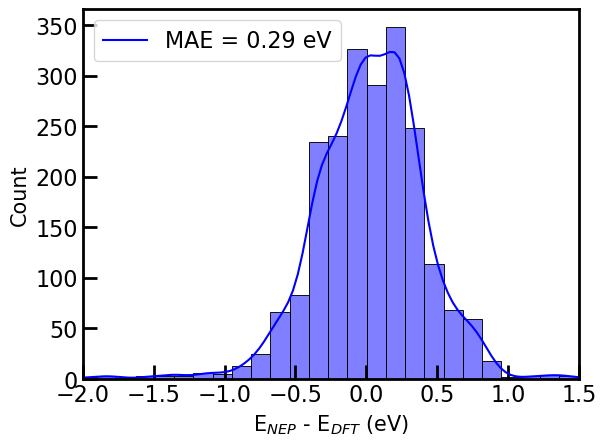

In [8]:
set_fig_properties([gca()])
mae_e=np.array(energy_predictions) - np.array(energy_ground_truth)
sns.histplot(mae_e, bins=50, kde=True, color='blue', edgecolor='black')
plt.xlim(-2,1.5)
plt.xlabel('E$_{NEP}$ - E$_{DFT}$ (eV)',fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(['MAE = %.2f eV'%mean_absolute_error(energy_ground_truth,energy_predictions)])
plt.savefig('hist_energy.png',dpi=300,bbox_inches='tight', pad_inches=0.1)